In [1]:
import os
import glob
import functools
import time
from __future__ import print_function
import random
import torch
import torch.optim as optim
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.utils.data import random_split, Subset
import torch.nn.functional as F
import torch.nn.parallel
from torch.autograd import Variable
from torch.nn import L1Loss

import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from IPython.display import clear_output

%matplotlib inline
#torch.manual_seed(1)

# Params 
MIN_POINTS = 300
IMG_H = 374
IMG_W = 1238
batch_size = 64

# Data folders
PC_DIR = '../data/processed/{}/training/point_clouds/'.format(MIN_POINTS)
IMG_DIR = '../data/processed/{}/training/image_2/'.format(MIN_POINTS)
CENTERS_DIR = '../data/processed/{}/training/centers/'.format(MIN_POINTS)
CALIB_DIR = '../data/processed/{}/training/calib/'.format(MIN_POINTS)

# Point cloud to image projection
def pcd_to_img(pcd, index):
    FRAME = f'{"0"*(6 - len(str(index)))}{index}'
    # Load binary point cloud
    with open(f'{CALIB_DIR}{FRAME}.txt', 'r') as f:
        calib = f.readlines()
    P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
    R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)
    # Reshape and drop reflection values
    pcd = pcd.reshape((-1, 4))
    points, reflectances = pcd[:, 0:3], pcd[:, 3]
    velo = np.insert(points,3,1,axis=1).T
    cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
    cam[:2] /= cam[2,:]
    return cam, reflectances

# Embed point cloud projection in camera image
def make_hybrid_image(border_size, pcd, img):
    """ Place projected point cloud image inside the RGB image """
    imsize = img.shape[-1]
    hybrid_img = img.detach().clone()
    pcd_center = pcd.detach().clone()[:, :, 
                                      border_size:imsize-border_size,
                                      border_size:imsize-border_size
                                     ]
    hybrid_img[:, :, border_size:imsize-border_size, 
               border_size:imsize-border_size] \
    = pcd_center.clone()
    return hybrid_img

# Visualization
def show_results(data, clip=4, save=False):
    """ Shows images
    parameters:
        data: list -- [input: torch.Tensor, output: ", truth: "]
        clip: int  -- The number of images in the batch to show
    """
    titles = ['in', 'out', 'true']
    # Don't try to show more than exists
    if clip > data[0].shape[0]:
        clip = data[0].shape[0]
    # Plot 
    for j in range(clip):
        fig, axes = plt.subplots(1, 3, sharey=True, figsize=(11,4))
        fig.suptitle('Lidar point cloud -> RGB', color="white")
        fig.patch.set_facecolor('black')

        for i in range(3):
            ax = axes[i]
            ax.imshow(((data[i][j].numpy().transpose(1, 2, 0) + 1)*127.5).astype('uint8'))
            ax.set_title(titles[i], color="white")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.savefig(str(j)+'.png', format='png')
    plt.show()

In [2]:
# Dataset classes
class ProjectedPointCloudDataset(Dataset):
    def __init__(self, folder, trans):
        self.folder = folder
        self.files = glob.glob(os.path.join(folder, '*.bin'))
        self.trans = trans
        
    def __getitem__(self, index):
        # little-endian float32
        pc = np.fromfile(os.path.join(self.folder, 
                              '{0:06d}.bin'.format(index)), '<f4')
        cam, refl = pcd_to_img(pc, index)
        [cH, cW] = np.load(os.path.join(CENTERS_DIR, 
                                        '{0:06d}.npy'.format(index)
                                       )
                          )
        # project 3d point cloud onto 2d
        u, v, z = cam
        # translate 2d image
        u -= cW - 128
        v -= cH - 128
        proj_mat = np.zeros((IMG_H, IMG_W))
        # populate matrix
        for idx in range(u.shape[0]):
            row = int(v[idx])
            col = int(u[idx])
            proj_mat[row, col] = z[idx]
            
        mat256 = proj_mat[:256, :256]
        # Simple 3 channels to match RGB condition image border
        pm3c = np.stack((mat256, 
                         mat256, 
                         mat256))
        # normalize to [-1, 1] 
        pm3c = torch.Tensor(pm3c)
        if self.trans:
            pm3c = self.trans(pm3c)
        pm3c =  2*(pm3c - pm3c.min())/(pm3c.max()-pm3c.min()) 
        pm3c -= 1
        return pm3c
    
    def __len__(self):
        return len(self.files)
    
class KittiLeftColorDataset(Dataset):
    """ Kitti Left Color (image_2) dataset"""
    def __init__(self, folder, trans=None):
        self.folder = folder
        self.files = glob.glob(os.path.join(folder, '*.png'))
        self.trans = trans
    
    def __getitem__(self, index):
        img_path = os.path.join(self.folder, 
                                f'{"0"*(6 - len(str(index)))}{index}.png')
        img = torch.Tensor(io.imread(img_path).transpose(2, 0, 1))
        if self.trans:
            img = self.trans(img)
        img = (img/127.5)
        img -= 1
        return img
    
    def __len__(self):
        return len(self.files)
    
class ConcatDataset(torch.utils.data.Dataset):
    """ Concatenate several datasets """
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return max(len(d) for d in self.datasets)

In [3]:
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/da39a525eb793614807db4330cfe9b2157bbe33a/models/networks.py#L539
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [4]:
# https://www.kaggle.com/code/truthisneverlinear/attention-u-net-pytorch#Attention-U-Net
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=6, out_channel=3):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

# Load data and models

In [5]:
proj_point_clouds = ProjectedPointCloudDataset(PC_DIR, trans = transforms.Resize(64, antialias=True))
images = KittiLeftColorDataset(IMG_DIR, trans = transforms.Resize(64, antialias=True))
dataset = ConcatDataset(images, proj_point_clouds)

split_fracs = [0.8, 0.2]
splits = [int(split_fracs[0]*len(dataset)), len(dataset) - int(split_fracs[0]*len(dataset))]
train_data, test_data = random_split(dataset, splits)

train_loader = torch.utils.data.DataLoader(train_data, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=3,
                                         pin_memory=True,
                                         drop_last=True
                                          )
n_batches = len(train_loader)

In [6]:

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load saved generator
G_Net = AttentionUNet()
G_Net.load_state_dict(torch.load("G"))
G_Net.to(device)
D_Net = NLayerDiscriminator(3)
D_Net.load_state_dict(torch.load("D"))
D_Net.to(device)
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()
L1 = L1Loss()

# Convention for real and fake labels during training
real_label = 1.
fake_label = 0.
lr = 0.00002

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D_Net.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G_Net.parameters(), lr=lr, betas=(0.5, 0.999))

# Train

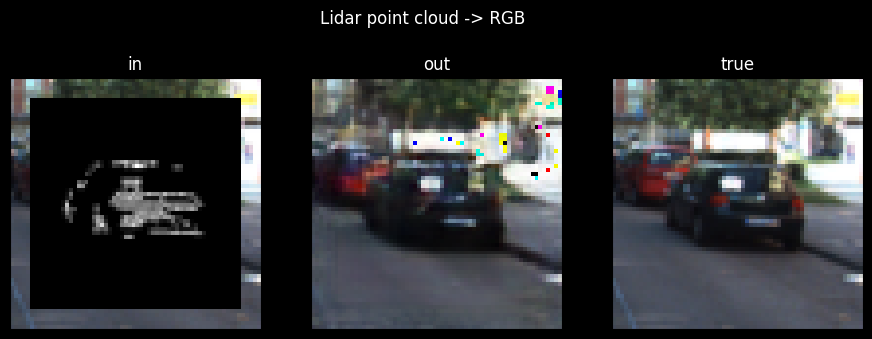

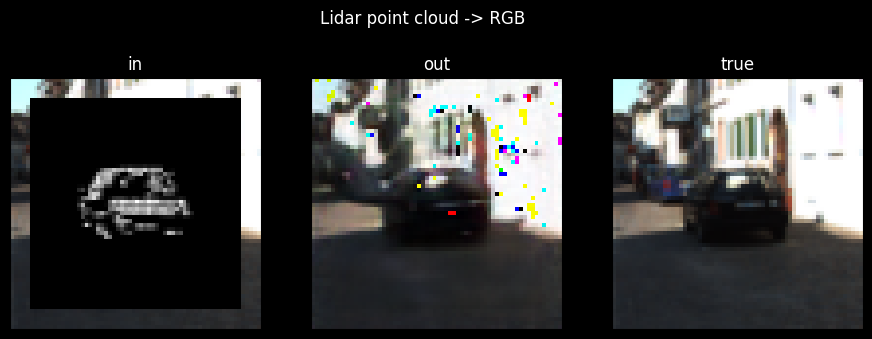

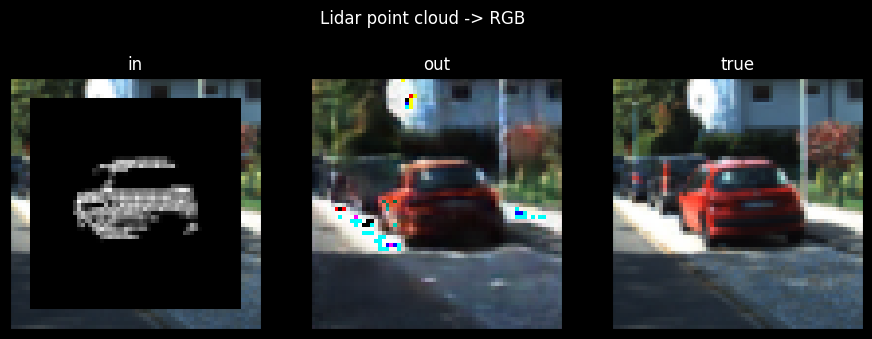

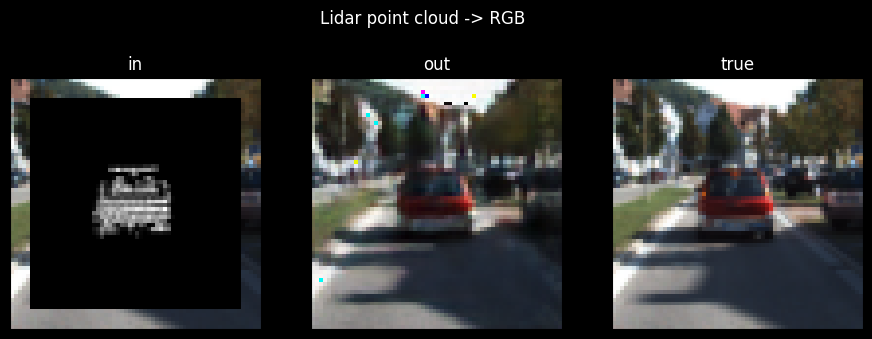

In [7]:
scaler = torch.cuda.amp.GradScaler()

for epoch in range(1):
    G_err_avg = 0.
    D_err_avg = 0.
    t_start = time.time()
    for i, batch in enumerate(train_loader):
        
        img_batch = batch[0].to(device)
        pc_batch = batch[1].to(device)
        hyb_batch = make_hybrid_image(5, pc_batch, img_batch)
        
        G_Net.zero_grad()
        D_Net.zero_grad()
        
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            t = torch.full((hyb_batch.shape[0],), 0, device=device)
            noise = torch.randn_like(hyb_batch).to(device)
            hyb_batch = torch.cat([noise, hyb_batch], 1)
            # Discriminator optimization
            # Generate fake
            fake_batch = G_Net(hyb_batch)
            
            # Classify real
            D_out_real = D_Net(img_batch).view(-1)
            # Classify fake
            D_out_fake = D_Net(fake_batch).view(-1)
        
            D_target_real = torch.full(D_out_real.shape, real_label, device=device)
            D_target_fake = torch.full(D_out_fake.shape, fake_label, device=device)
    
            D_err_real = criterion(D_out_real, D_target_real)
            D_err_fake = criterion(D_out_fake, D_target_fake)
            D_err = D_err_real + D_err_fake
        
        # Scaler
        scaler.scale(D_err).backward(retain_graph=True)
        scaler.step(optimizerD)
        
        # No scaler
        #D_err.backward()
        #optimizerD.step()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            # Generator optimization
            fake_batch = G_Net(hyb_batch)
            D_out_fake = D_Net(fake_batch).view(-1)
            
            G_target = torch.full(D_out_fake.shape, real_label, device=device)
            
            G_err = criterion(D_out_fake, G_target) + 100*L1(fake_batch, img_batch)
        # Scaler
        scaler.scale(G_err).backward()
        scaler.step(optimizerG)
        scaler.update()
        
        # No scaler
        #G_err.backward()
        #optimizerG.step()
        
        with open('p2p_losses_test.txt', 'a') as f:
            f.write(f'{epoch}, {i}, {D_err}, {G_err}\n')
        t_end = time.time()
        print(D_err.item(), G_err.item())
        
    if epoch % 10 == 0:
        torch.save(G_Net.state_dict(), "G_test")
        torch.save(D_Net.state_dict(), "D_test")
        
    if (epoch + 1) % 1 == 0:
        clear_output(wait=True)
        display_data = [hyb_batch[:, 3:, :, :].detach().cpu(), 
                        fake_batch.detach().cpu(), 
                        img_batch.detach().cpu()]
        show_results(display_data, clip=4, save=False)
        plt.show()        

# Generate on test dataset

In [8]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=3,
                                         pin_memory=True,
                                         drop_last=True
                                        )

test_iter = iter(test_loader)

/tmp/ipykernel_65608/4168537226.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, sharey=True, figsize=(11,4))


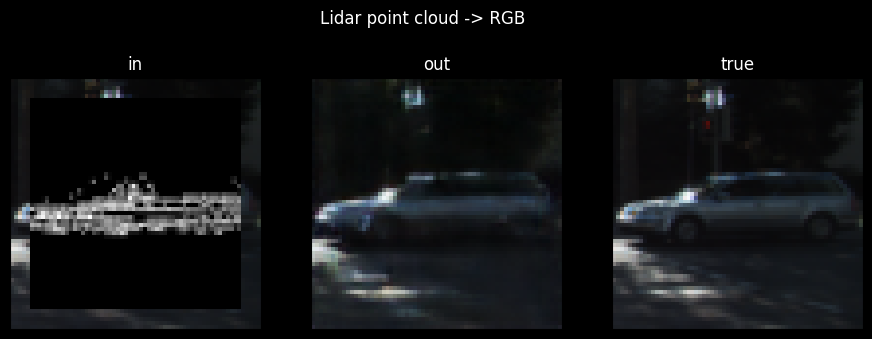

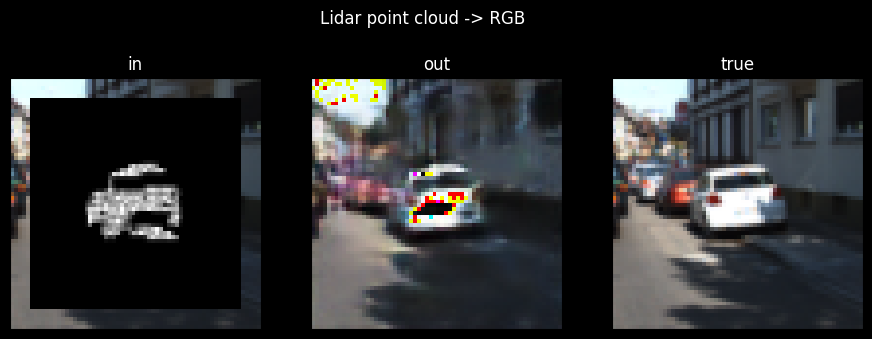

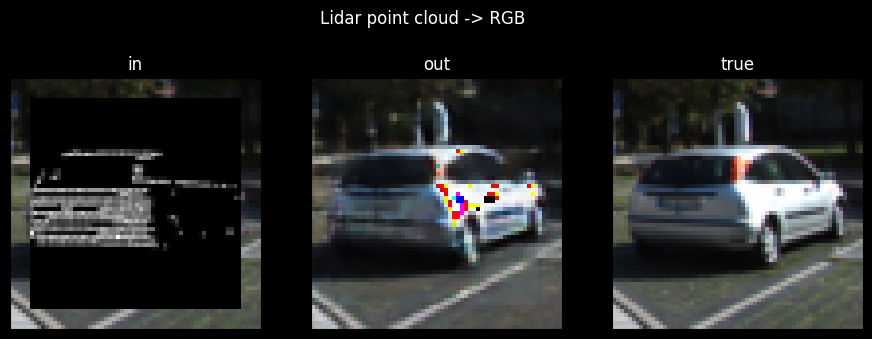

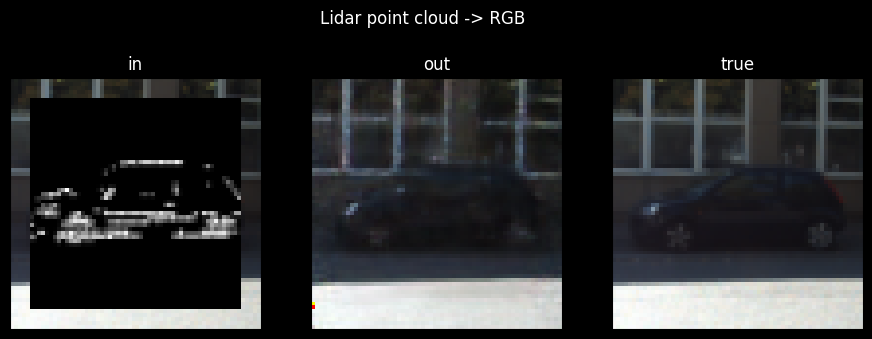

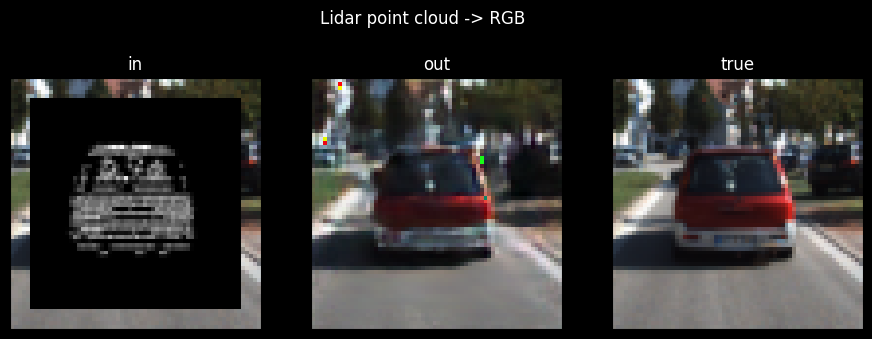

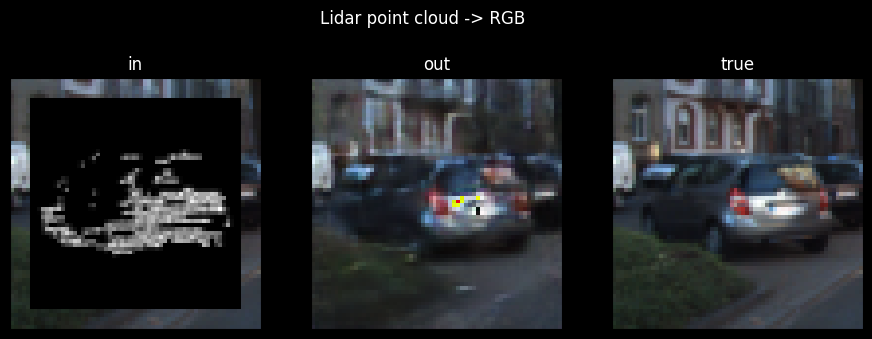

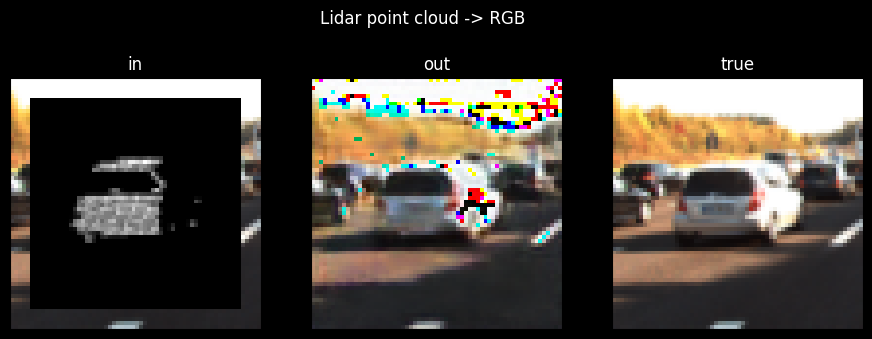

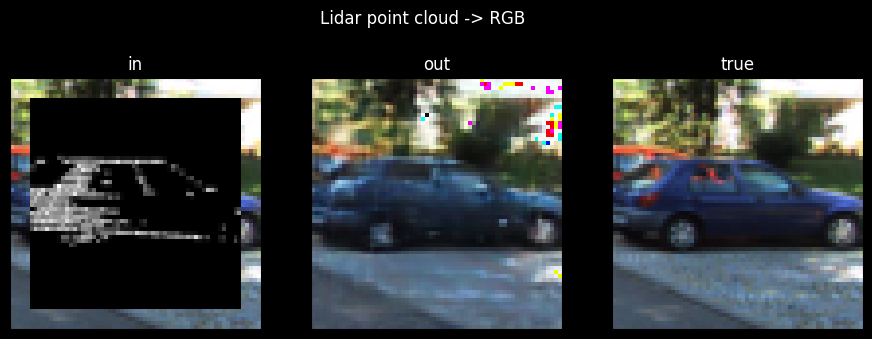

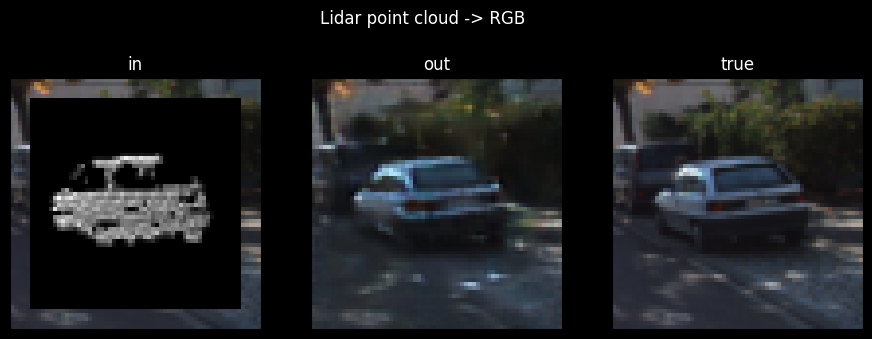

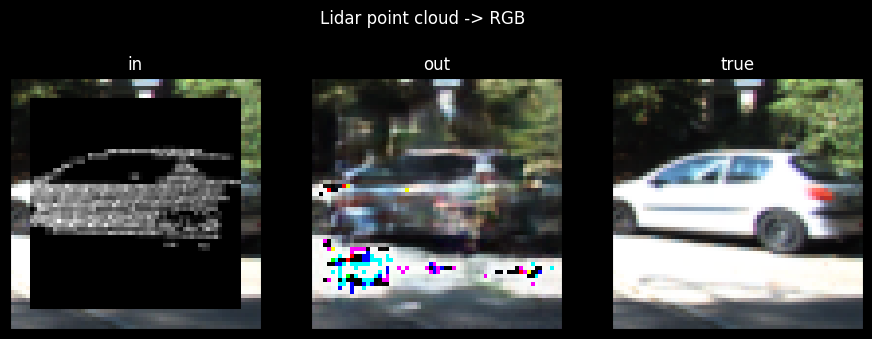

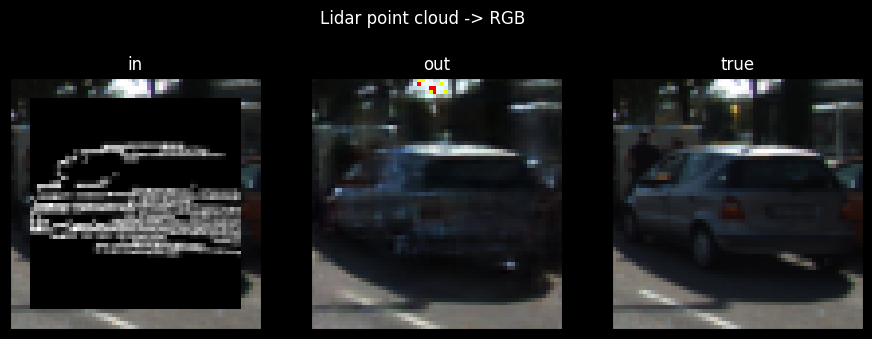

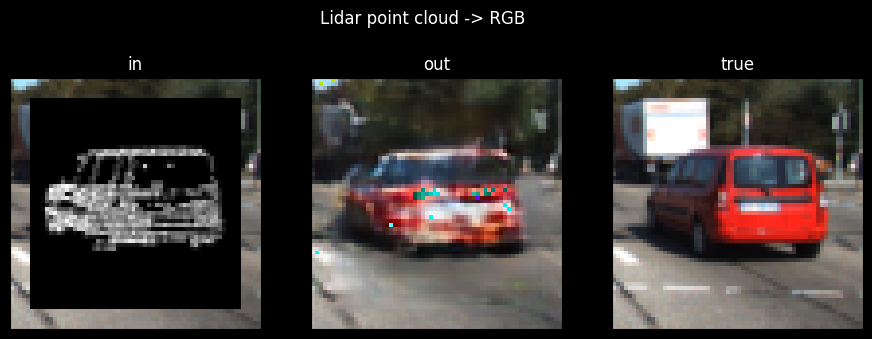

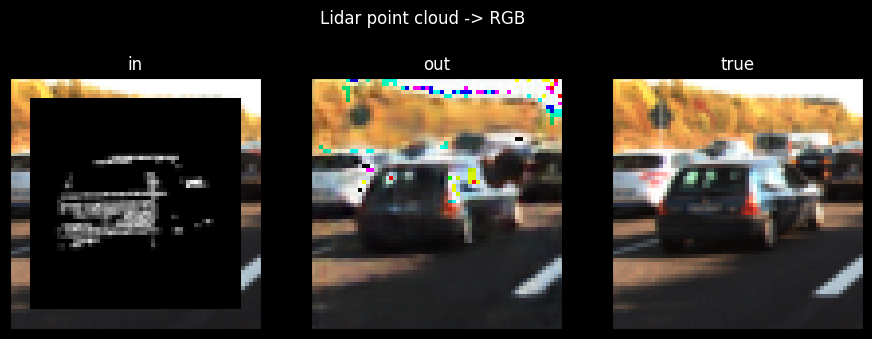

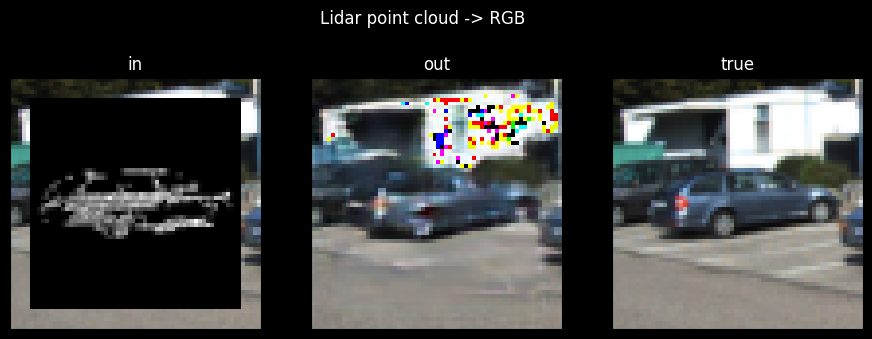

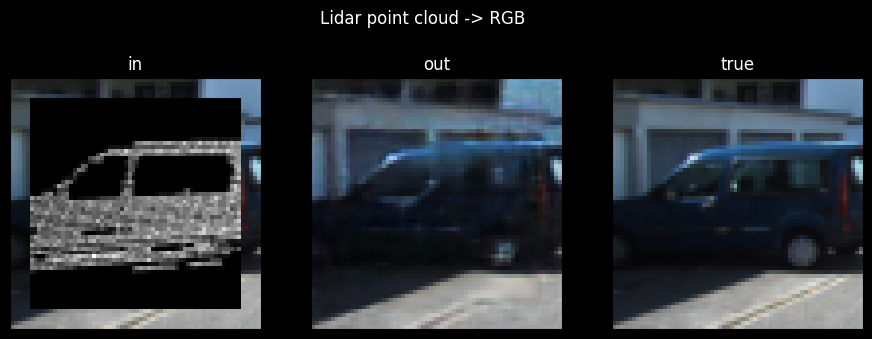

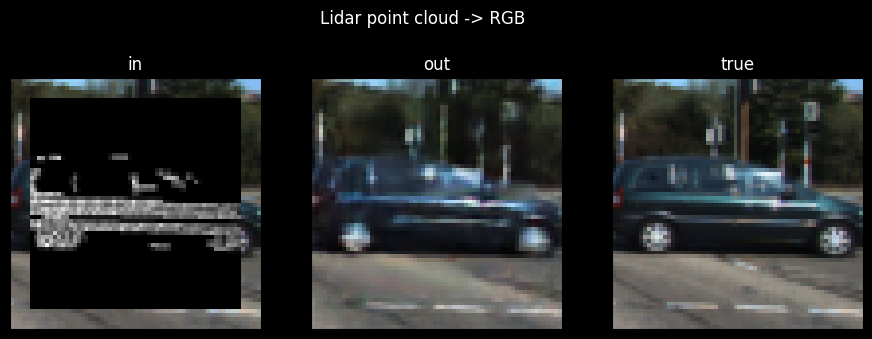

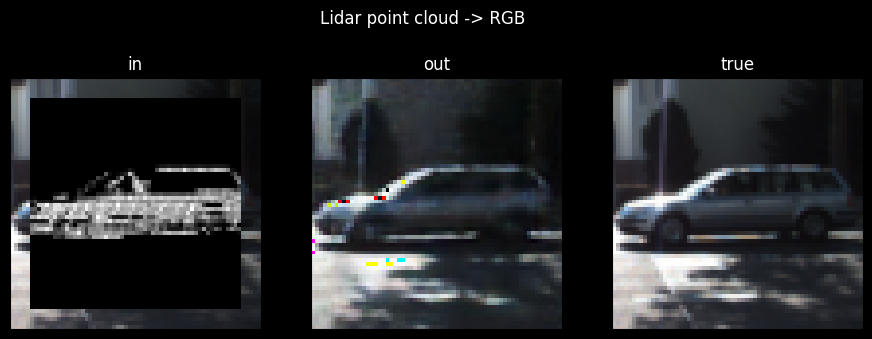

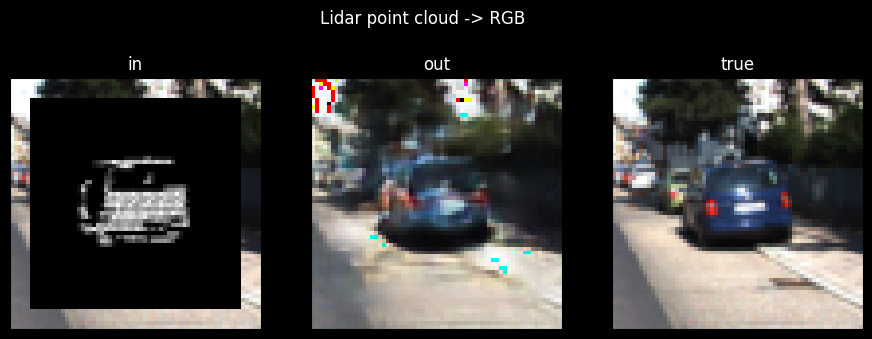

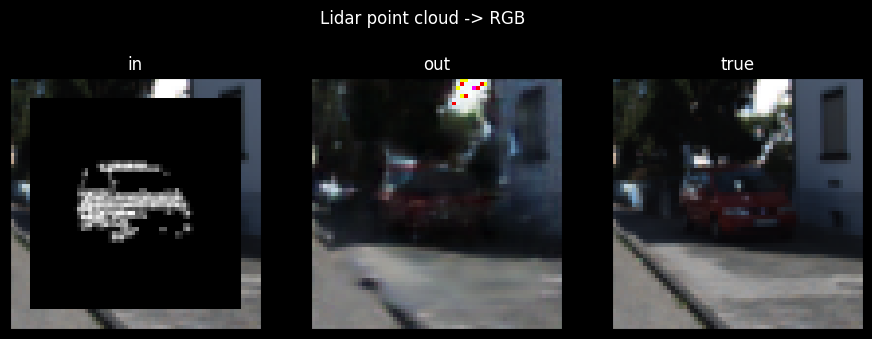

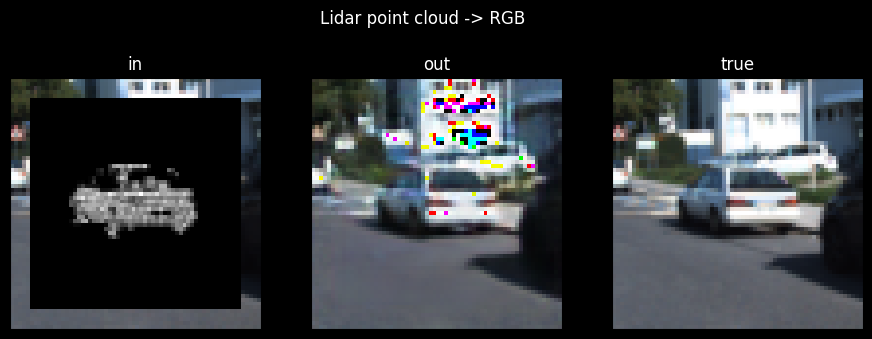

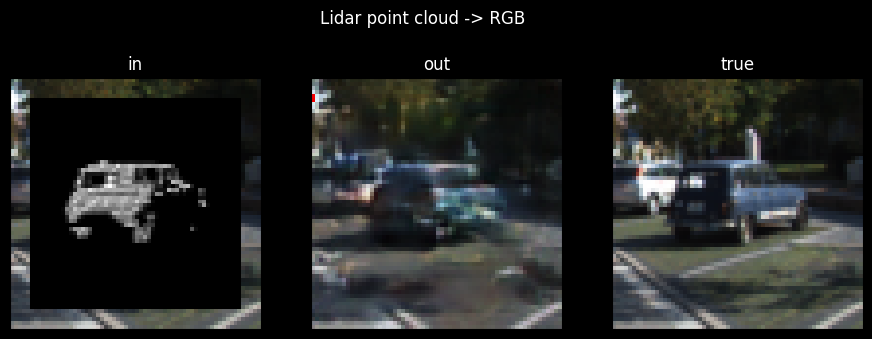

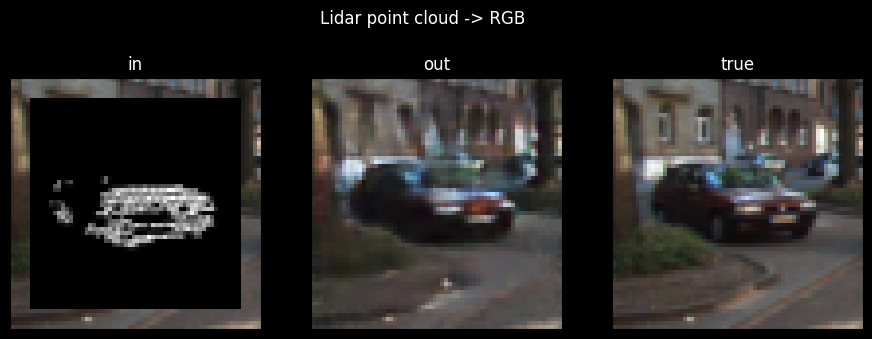

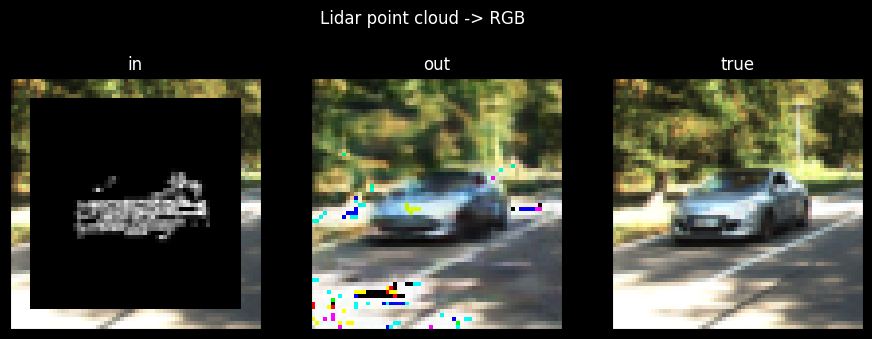

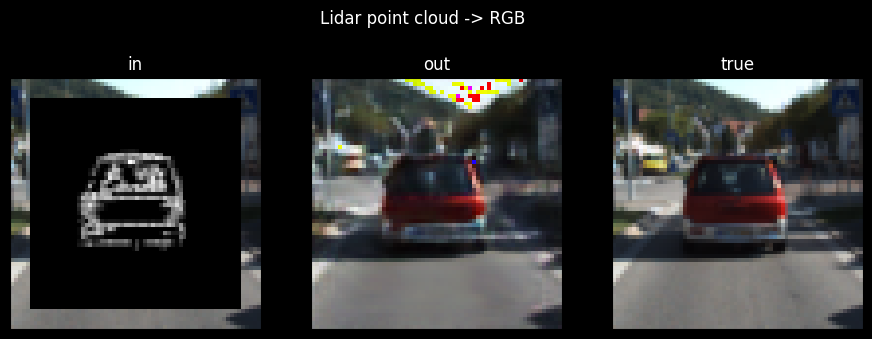

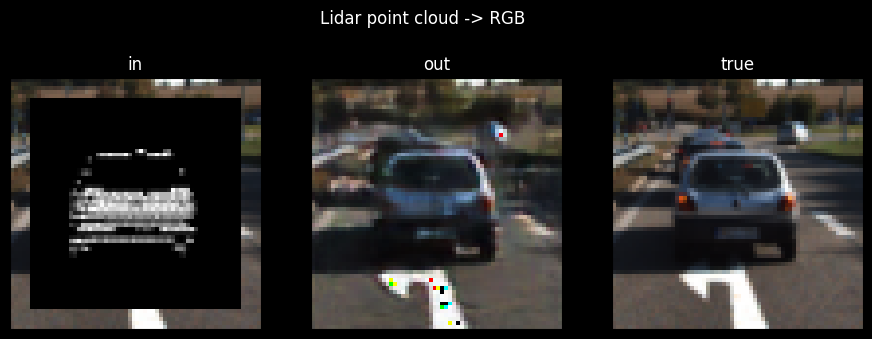

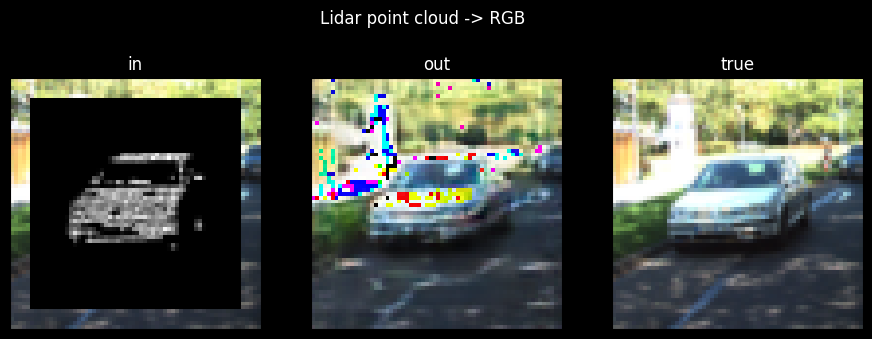

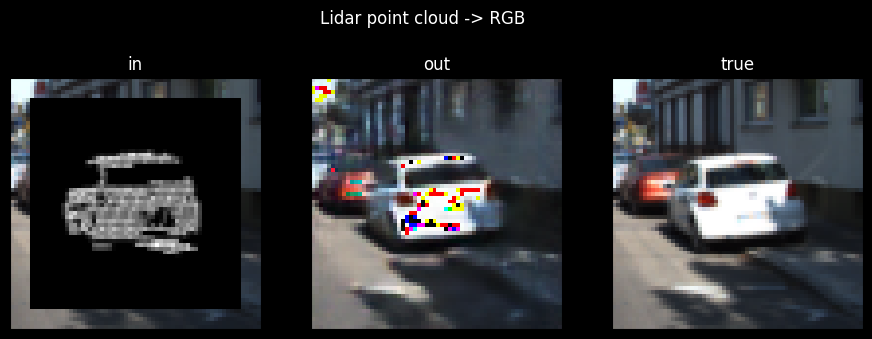

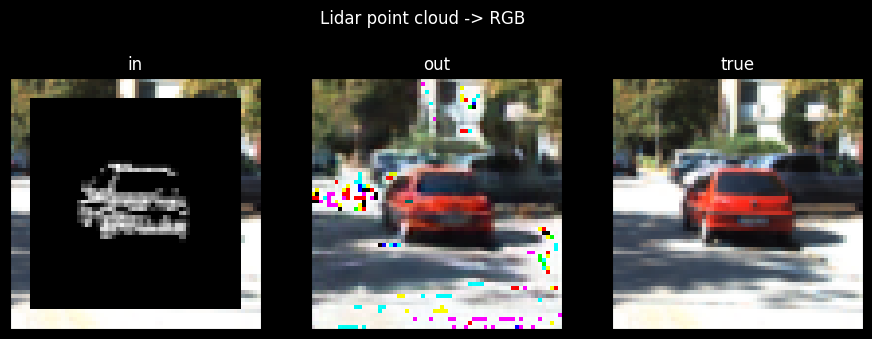

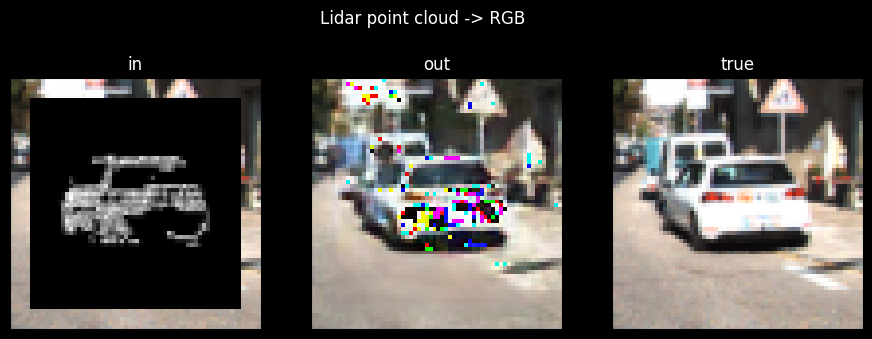

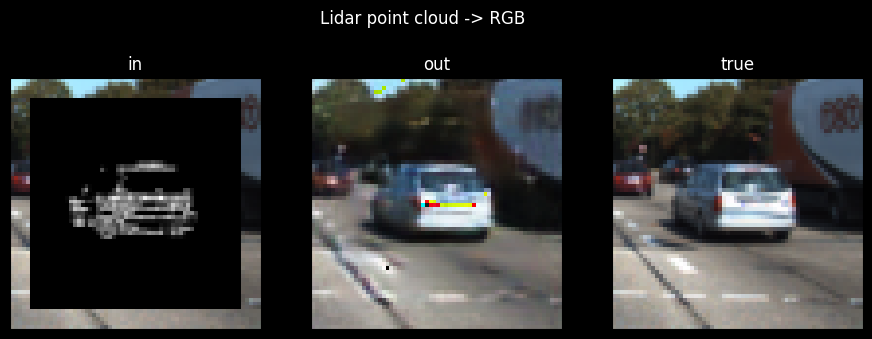

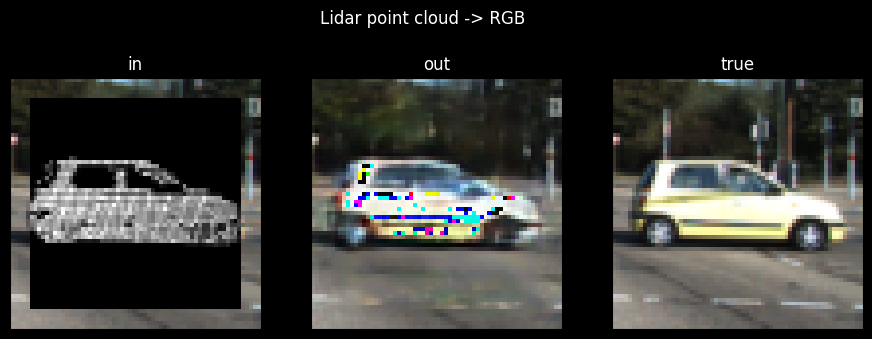

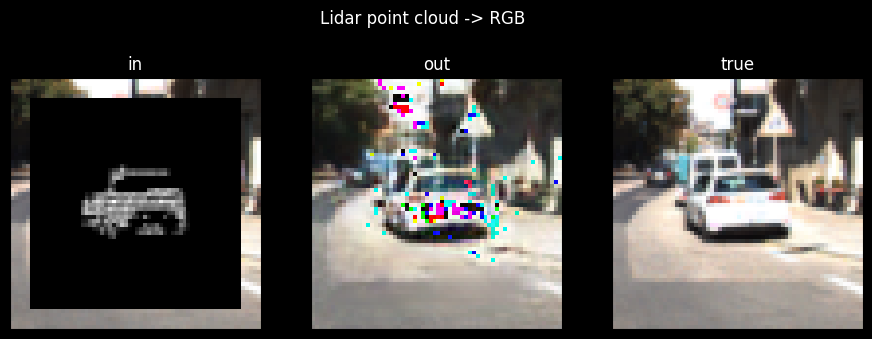

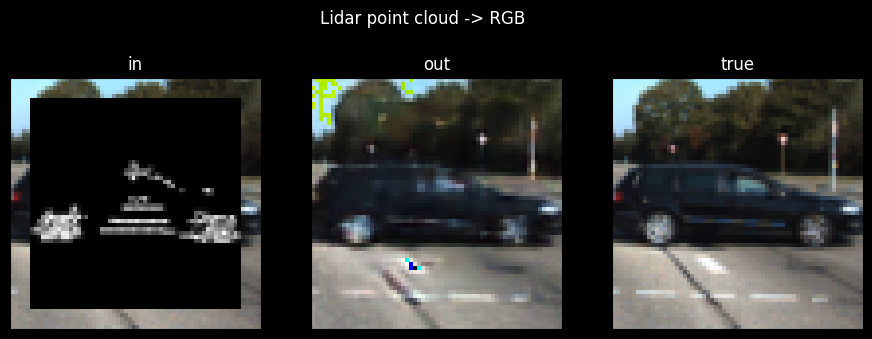

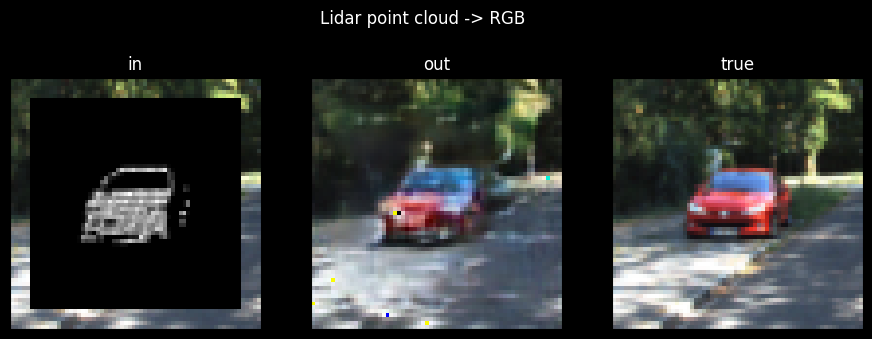

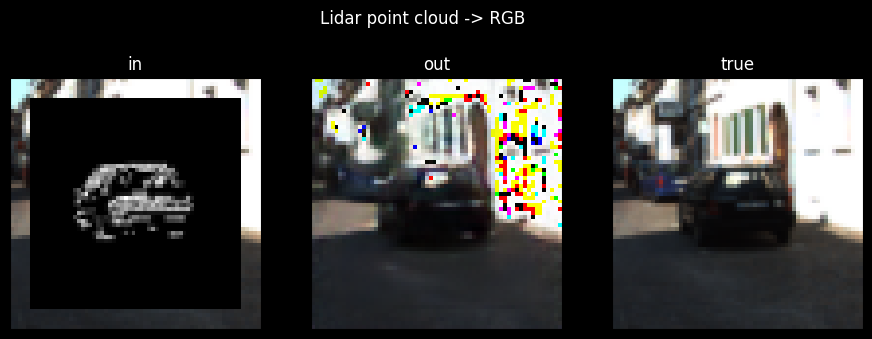

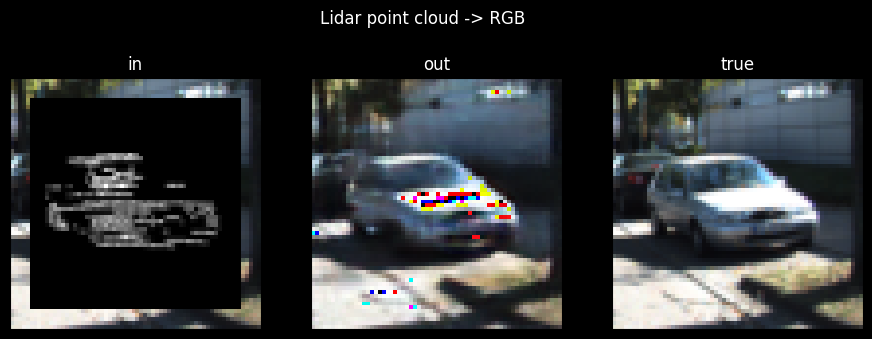

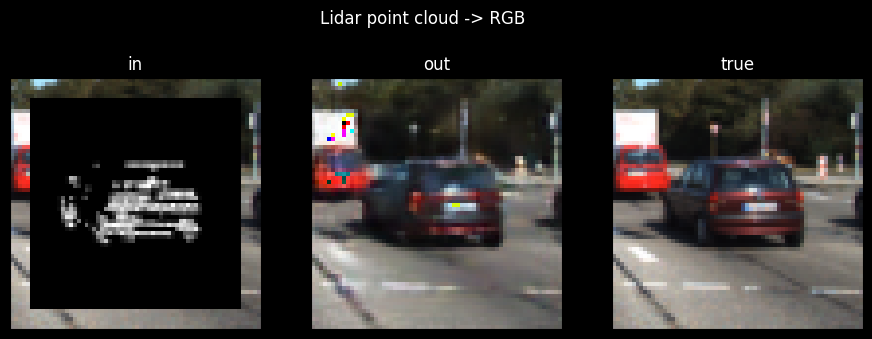

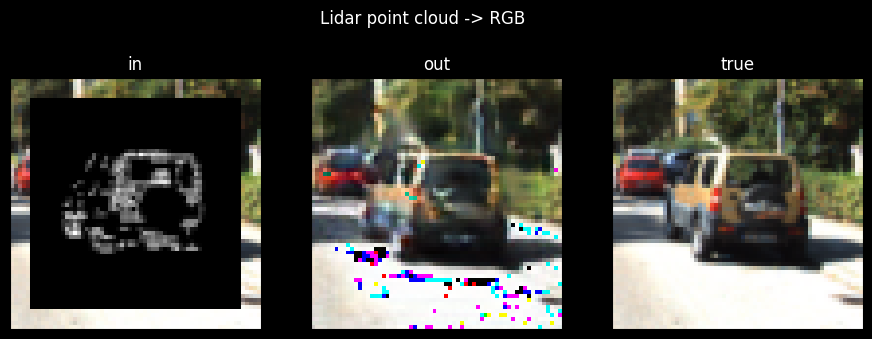

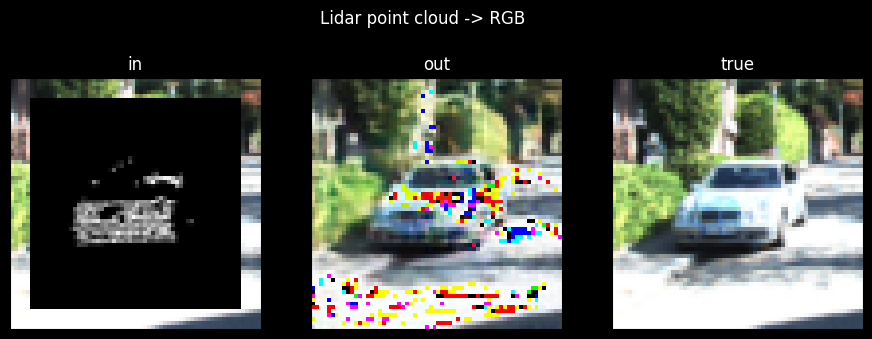

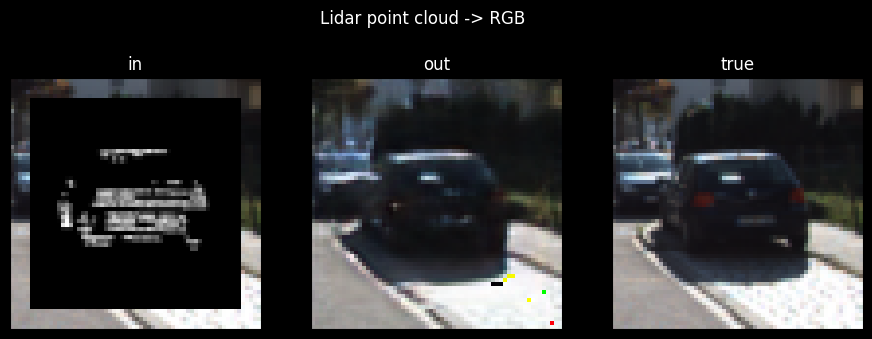

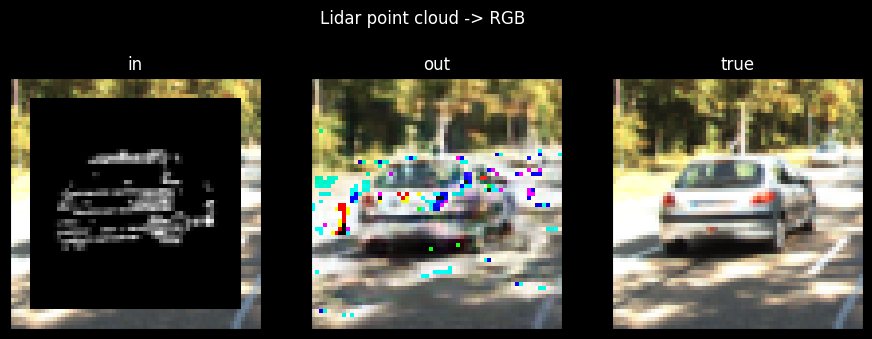

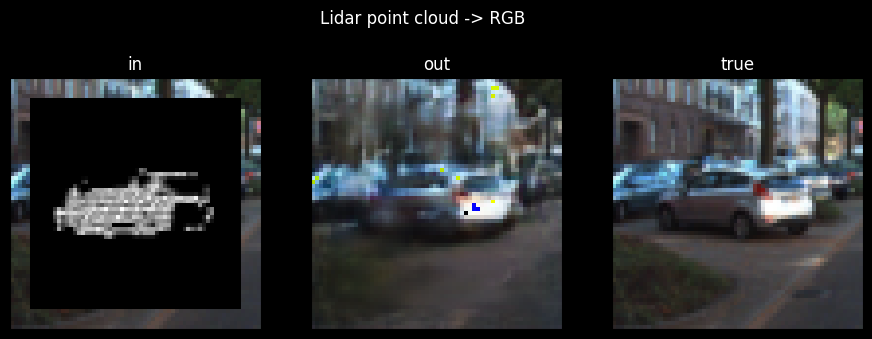

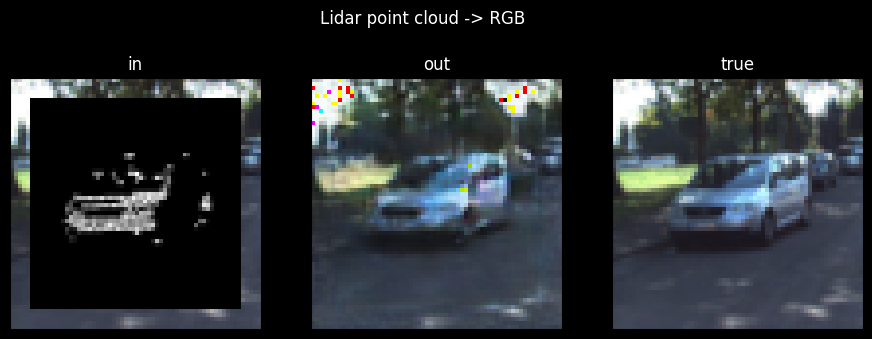

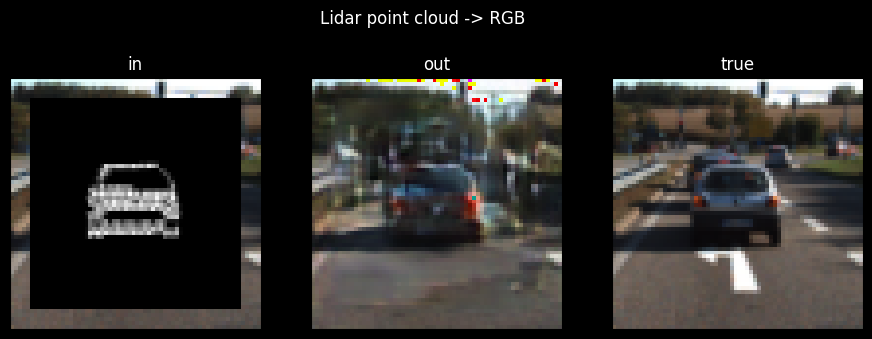

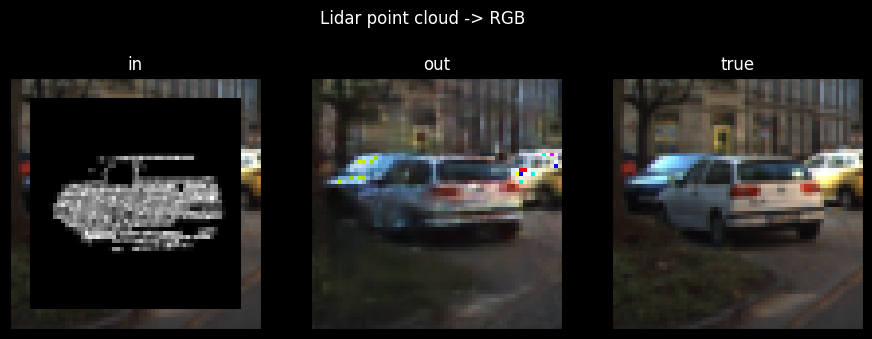

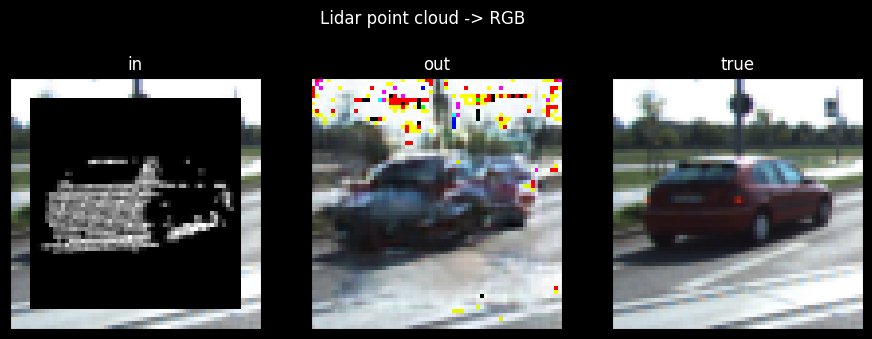

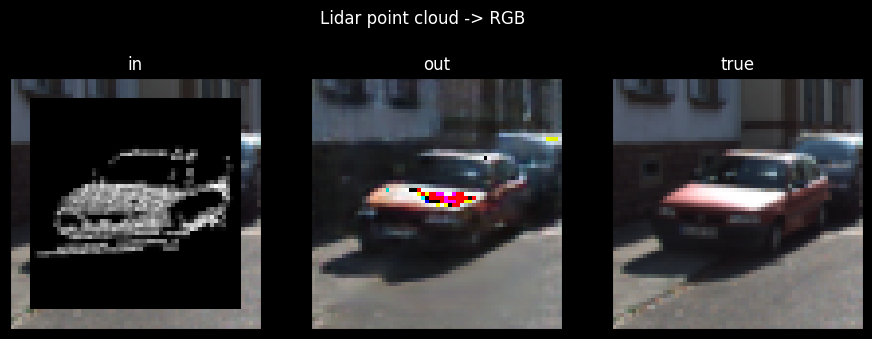

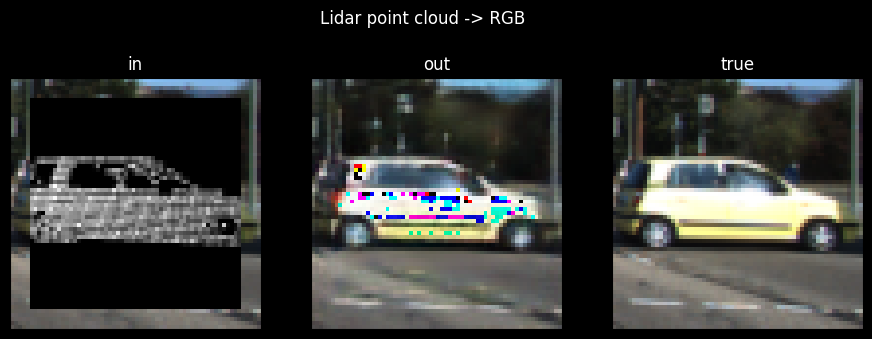

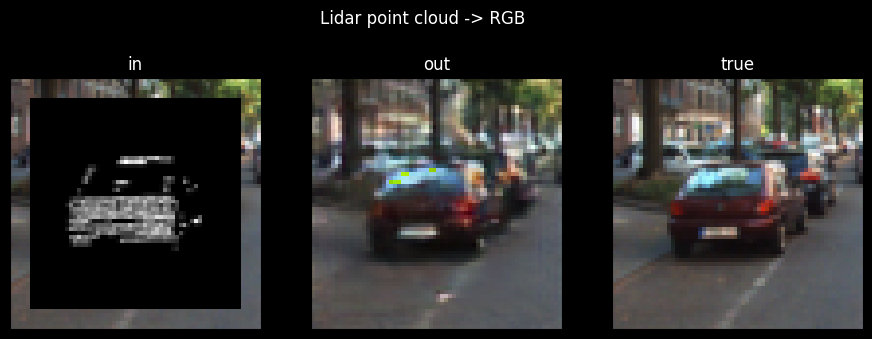

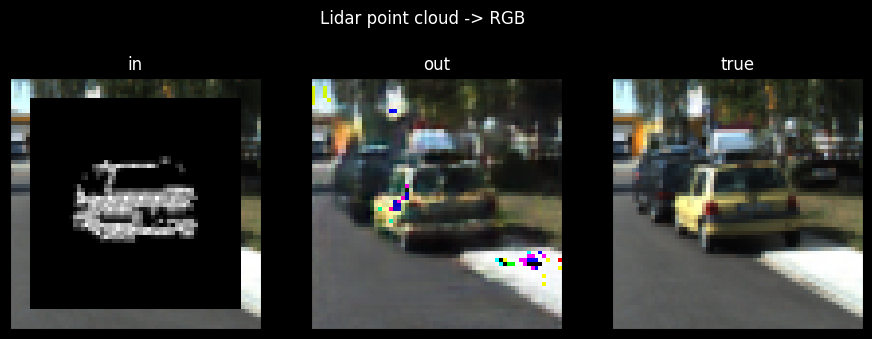

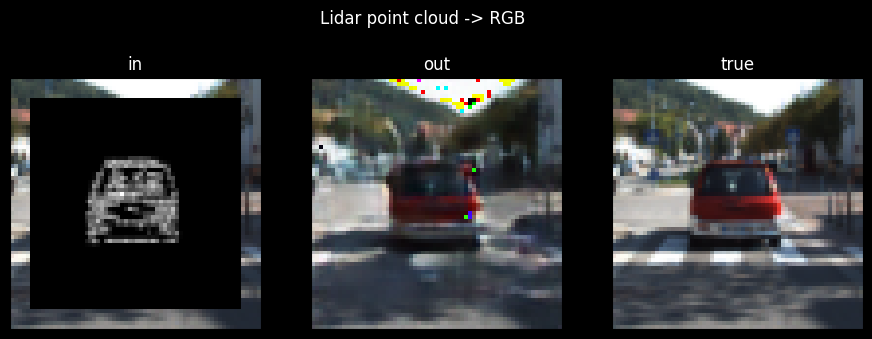

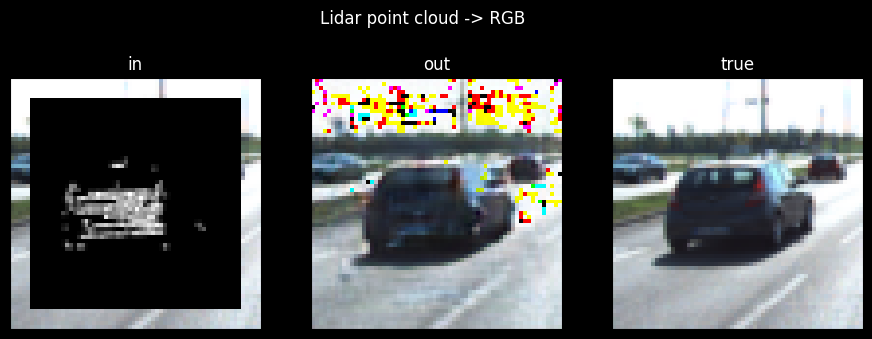

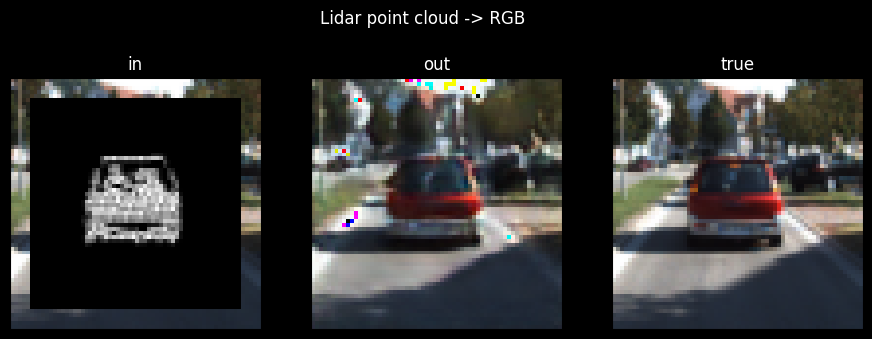

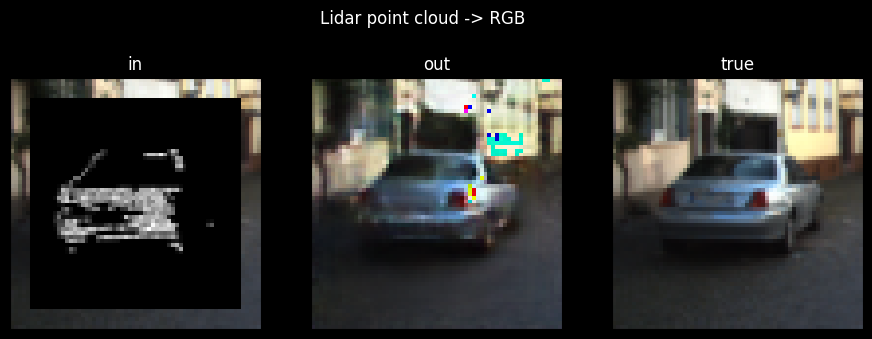

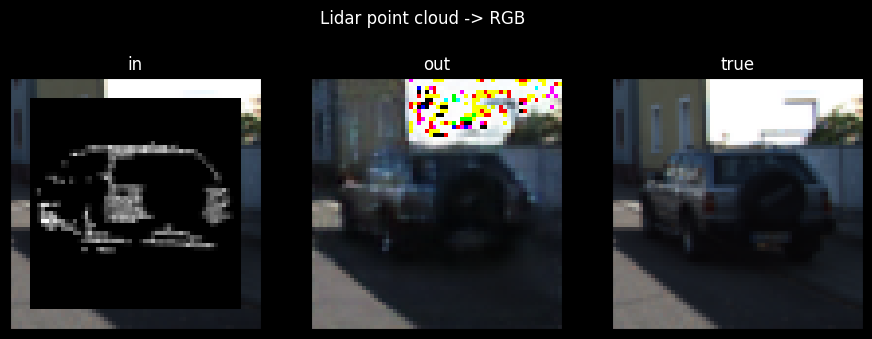

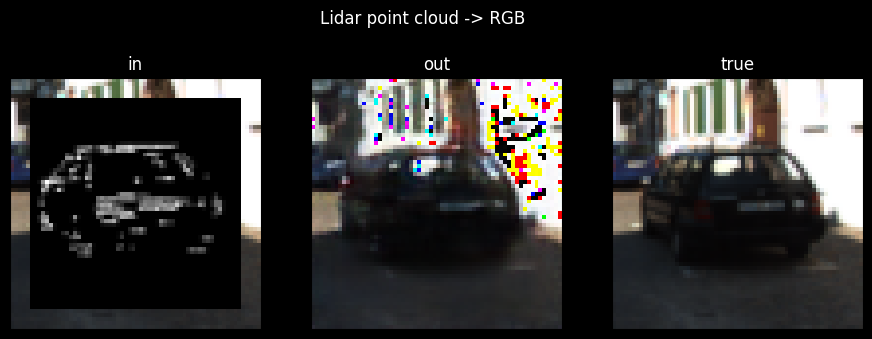

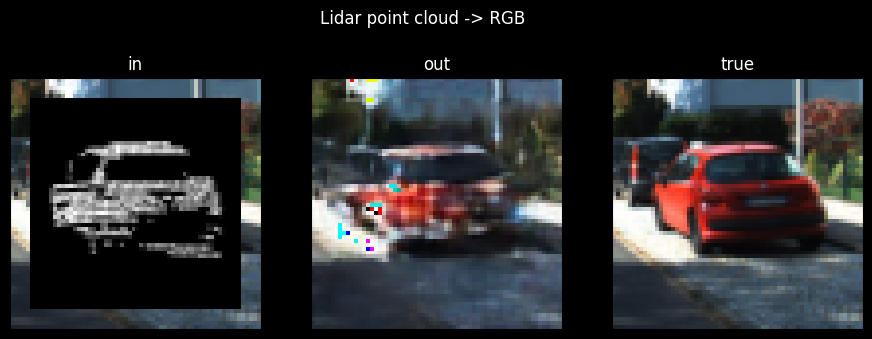

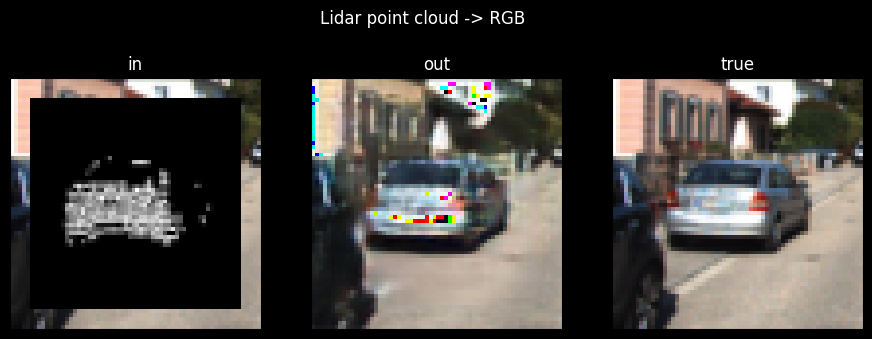

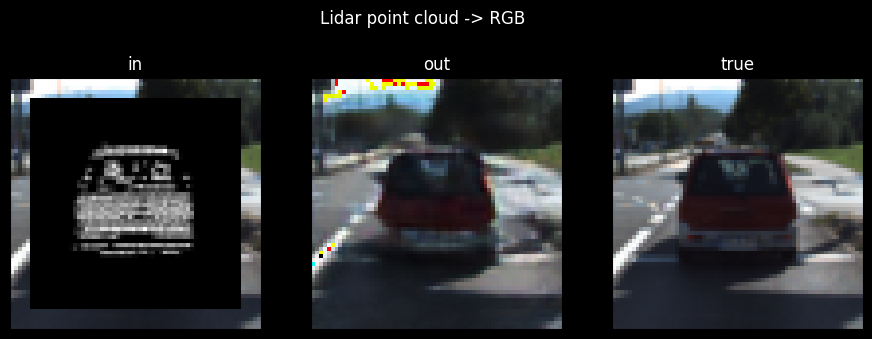

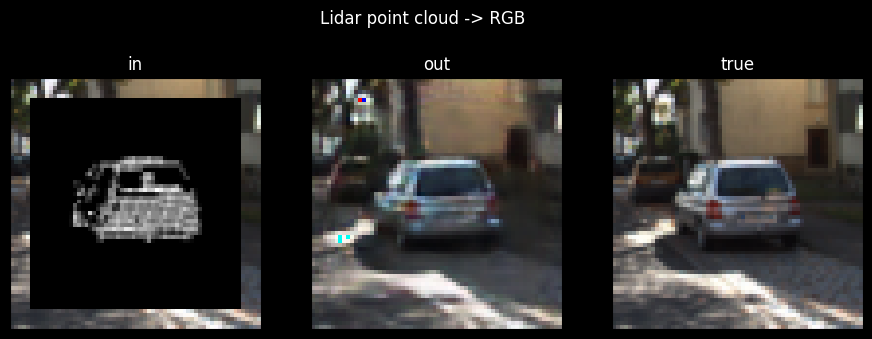

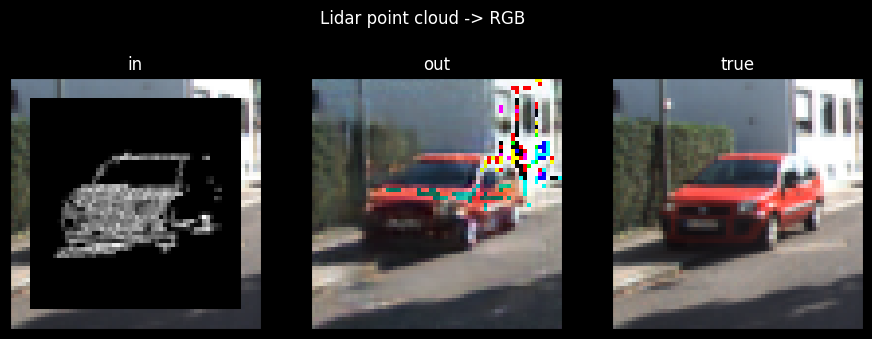

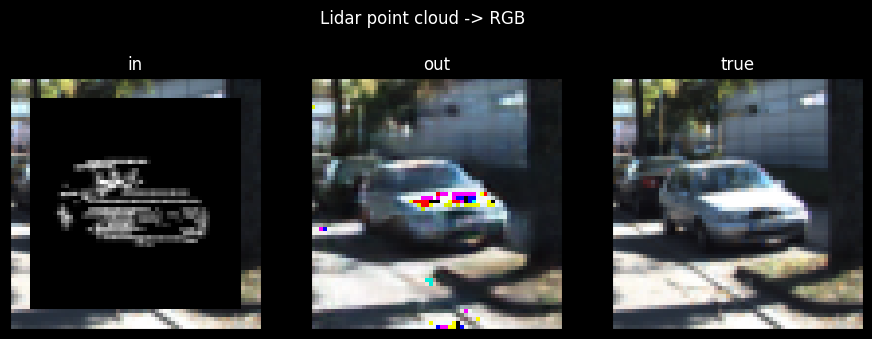

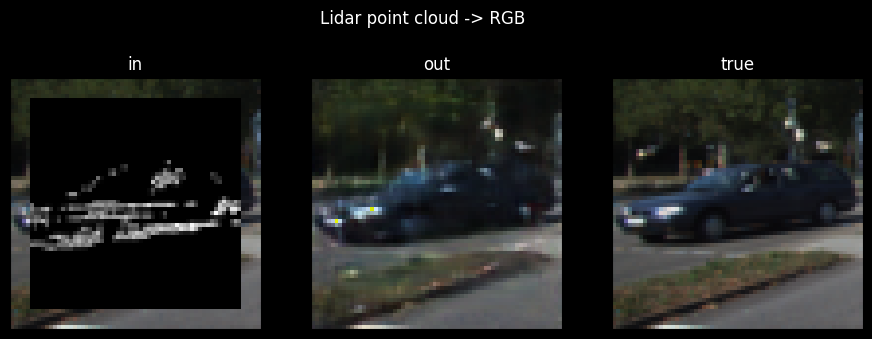

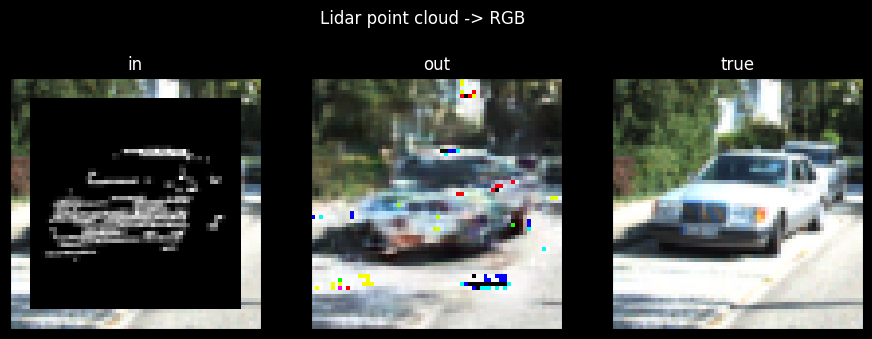

In [9]:
img_batch, proj_batch = next(test_iter)
with torch.no_grad():
    hyb_batch = make_hybrid_image(5, proj_batch, img_batch).to(device)
    noise = torch.randn_like(hyb_batch).to(device)
    hyb_batch = torch.cat([noise, hyb_batch], 1)
    generated = G_Net(hyb_batch)

display_data = [hyb_batch[:,3:,:,:].detach().cpu(), 
                generated.detach().cpu(), 
                img_batch.detach().cpu()]
show_results(display_data, clip=100, save=True)

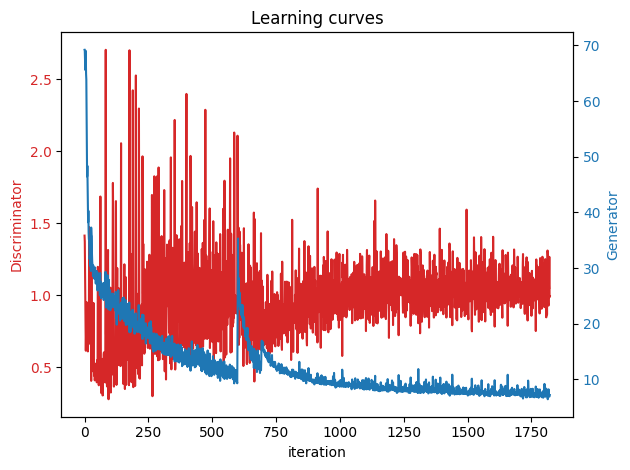

In [11]:
import numpy as np
import matplotlib.pyplot as plt
with open('p2p_losses.txt') as f:
    lines = f.readlines()
p2p_losses = []
for line in lines:
    line = line.strip('\n').split(',')
    D_loss = float(line[2]) 
    G_loss = float(line[3])
    p2p_losses.append([D_loss, G_loss])
    
p2p_losses = np.array(p2p_losses)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('Discriminator', color=color)
ax1.plot(p2p_losses[:, 0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Generator', color=color)  
ax2.plot(p2p_losses[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Learning curves')
fig.tight_layout() 
plt.show()